In [315]:
import numpy as np
import matplotlib.pyplot as plt

In [316]:
#Constants for the Code

V2 = 0
V3 = 256000 #Newtons
E_al = 10.5 *10**3* 6.89476 *10**6 #Pa #Youngs Modulus of aluminium, the material of stringer
#0.020 − 0.062𝑖𝑛 thickness range for the “L” direction
R = 1.95 #m #Distance from origion to LE
A_s = 150 * (1/1000)**2 #m^2 #Stringer Area
t = 2.95/1000 #m #Thickness in inches it is 0.1161417

c = 8*R #Chord

print("E_al 2024-T861:", E_al/(10**9), "GPa")

x2i = np.array([
    7*R,
    R,
    0,
    -R,
    -2*R/3,
    R
])

x3i = np.array([
    0,
    6/7*R,
    R,
    0,
    -R/3,
    -6*R/23
])

len = np.size(x2i)

x2c = (7*R -2*R/3 + R)/6
x3c = (6/7*R + R - R/3 - 6*R/23)/6

print('x2c: ', x2c, 'm')
print('x3c: ', x3c, 'm')

#print(x2c/R, x3c/R)

x2i_c = x2i-x2c
x3i_c = x3i-x3c

E_al 2024-T861: 72.39498 GPa
x2c:  2.3833333333333333 m
x3c:  0.410455486542443 m


In [317]:
H22c = 0
H33c = 0
H23c = 0

for i in range(len):
    #print(x2i[i])
    H22c += E_al*A_s*(x3i_c[i])**2
    H23c += E_al*A_s*(x3i_c[i])*(x2i_c[i])
    H33c += E_al*A_s*(x2i_c[i])**2
#This method is faster and only yields errors in the float, ie e-15

print("H22c: ", H22c, 'N m^2')
print("H23c: ", H23c, 'N m^2')
print("H33c: ", H33c, 'N m^2')



H22c:  68050584.36934105 N m^2
H23c:  -29940944.958260868 N m^2
H33c:  1795449800.235 N m^2


In [318]:
del_fi = np.array([]) #shear flow due to the presence of stringers, i

for i in range(len):
    shearflowinx2 = x2i_c[i]*(H22c*V2 - H23c*V3)/(H22c*H33c - (H23c)**2)
    shearflowinx3 = x3i_c[i]*(H23c*V2 - H33c*V3)/(H22c*H33c - (H23c)**2)

    calc = -E_al*A_s*( shearflowinx2 - shearflowinx3)
    del_fi = np.append(del_fi, calc)
#print(del_fi)

#We make a cut along 12
#therefore, our shearflow in the skin calcs start at cut = 1

cut = 1
fo_ij = np.zeros(len)


for i in range(len):
    if(i == cut - 1):
        fo_ij[cut - 1] = 0
    else:
        fo_ij[i] = fo_ij[i-1] + del_fi[i]

print("Open Shear Flow for skin sections, 12 to 61 \n",fo_ij, 'N/m')

Open Shear Flow for skin sections, 12 to 61 
 [      0.          -51595.98164891 -113317.89653291  -93452.38642517
  -47283.22568237   -9159.61776158] N/m


Now time to calculate the distance between stringers

To do this, We will look at x2i and x23, given these points we can find the distance according to the following.

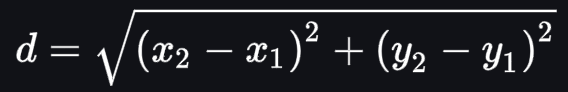

In [319]:
#Closing Shear Flow calculations

#print(x2i)
#print(x3i)

l = np.zeros(len)
#Shape of length array
#Length of segments([1_2,2_3,3_4,4_5,5_6,6_1])
#Segments 3_4 and 4_5 are circular to make the leading edge of the airfoil
#the rest are linear
for i in range(len):
    #print(l)
    if(i == 2):
        l[i] = np.pi/2 * np.abs(x3i[i]-x3i[i+1]) #R 
        #print('checkpoint reached', l[i])
    elif(i == 3): #These 2 if statements cover the circular radii that create the leading edge.
        
        l[i] = np.pi/2 * np.abs(x2i[i]-x2i[i+1]) #R/3 
        #print('This one too', l[i])
    elif(i == len - 1):
        
        l[i] = np.sqrt((x2i[i] - x2i[0])**2 + (x3i[i] - x3i[0])**2)
        #print('And here as well', l[i])
    else:
        
        l[i] = np.sqrt((x2i[i+1] - x2i[i])**2 + (x3i[i+1] - x3i[i])**2)
        #print(i, l[i])
    
        #print(l)
    
#print('end: ', l)
#I think this might be a use case for linked list but I am not a CS major so I don't care

perimeter = np.sum(l)
print('Perimeter: ', perimeter, 'm')
#print(perimeter)

#print(l_i)

#Now to calcualte CLosing shear flow
#Notice that this is just the dot product betwen open shear flow and segement length
f_c = -np.dot(fo_ij, l)/perimeter
print('Closing Shear flow: ', f_c, 'N/m')

Perimeter:  32.83677644599214 m
Closing Shear flow:  24522.300646891432 N/m


Now comes time for the area calculations,

The area of a traingle can be beautifully represented by the determinant of a matrix following

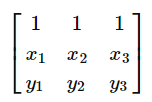

The full cacluation is the following,

$$A_{ijk} = \frac{1}{2} \cdot \left|{ \text{Determinant}}\right|$$

In [320]:
#Area code
ones = np.ones(3)

def tri_area(x1,x2,y1,y2):#x0 and y0 are ALWAYS the origin, they will always be 0
    x = np.array([x1,x2,0])
    y = np.array([y1,y2,0])

    A = np.vstack((ones,x,y))
    Area = 1/2 * np.abs(np.linalg.det(A))
    return Area
Area_A = tri_area(-1,9,5,2)
#print(B)
#print(Area_A)
#print(tri_area(6,9,-1,2))

#The above checks complete the area code

x2i = np.array([
    7*R,
    R,
    0,
    -R,
    -2*R/3,
    R
])

x3i = np.array([
    0,
    6/7*R,
    R,
    0,
    -R/3,
    -6*R/23
])

#For implementation
A_i = np.zeros(len)
for i in range(len):
    if (i + 1 > len-1):#The final case where we consider points 6_1
        A_i[i] = tri_area(x2i[0],x2i[i],x3i[0],x3i[i])
        break
    elif (i == 2):
        A_i[i] = np.pi/4*(x3i[i])**2
    elif (i == 3): #These 2 if statements cover the circular areas
        A_i[i] = np.pi/4*(R/3)**2 - 1/2*(R/3)*(R/3) + tri_area(x2i[i],x2i[i+1],x3i[i],x3i[i+1])
    else:
        A_i[i] = tri_area(x2i[i],x2i[i+1],x3i[i],x3i[i+1])

A_tot = np.sum(A_i)        
#print(A_i)
print('Total Area: ', A_tot, 'm^2')



#I truly loathe if statements, evidence that there can be a better way to do it but for now this is it

#SHEAR CENTER
x2k = 1/V3 * (2*A_tot*f_c + 2*np.dot(fo_ij,A_i))

print('Shear Center: ',x2k,'m')


Total Area:  21.48580724035422 m^2
Shear Center:  -0.44946502469543886 m


TO calcualte torsion shear flow we need the moment caused by V3


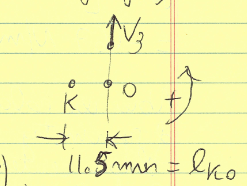

However, V3 acts at a distance away from the origin, so we have to include this distance in our calculation of the moment arm

Right hand rule shows us that we should expect a positive moment from x2k


In [321]:
#Moment and f_t and resulting shear
lk0 = R - x2k #R is the x2 length from the origin

M_t = V3 * lk0
#print(M_t)

#Now we simply apply Budt Batho Formula

f_t = M_t/(2*A_tot)

print('Torsion Shear Flow: ', f_t, 'N/m')


#Now to calculate resulting shear,
f_ij = fo_ij + f_c + f_t
print('Total Shear Flow', f_ij, 'N/m')

Torsion Shear Flow:  14294.623410014021 N/m
Total Shear Flow [ 38816.92405691 -12779.05759201 -74500.972476   -54635.46236827
  -8466.30162547  29657.30629533] N/m


Now that we have calcuated the total shear flow in each segment, we can begin the failure analysis in the system.

The skin thickness of each segment is $2.95 \text{mm} \approx 0.116 \text{in}$. 

Knowing the $F_{su}$ of the material will yield the ultimate shear allowable on the material. In our case, Aluminum 2024-T861 has a ultimate shear stress of 39 Ksi in our desired thickness.

$F_{su} = 39 \text{Ksi} = 268895640.0 \text{Pa} \approx 248.9 \text{MPa}$

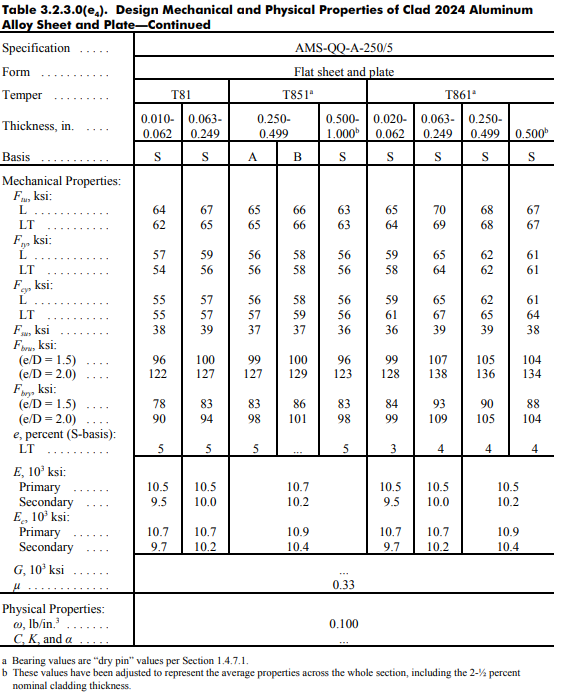

Following the definition of Factor of safety yields the following,

$\tau_{ij} = \frac{\vartheta_{ij}}{t}$

$FOS = \frac{F_{su}}{\tau_{ij}} = \frac{F_{su} \cdot t}{\vartheta_{ij}}$

Where $\vartheta_{ij}$, is the shear flow in each segment, i.e. $\vartheta_{12}$,$\vartheta_{23}$,$\vartheta_{34}$,etc.

In [322]:
nu = 0.33
G = E_al/(2*(1+nu))

print('Shear Modulus: ', G)

F_su = 39 * 6.89476 * 10**6

FOS = np.abs(F_su/f_ij*t)

#print(FOS)

FOS = np.round(FOS,2)
print('Factor of Safety: ', FOS)

Shear Modulus:  27216157894.73684
Factor of Safety:  [20.44 62.07 10.65 14.52 93.69 26.75]
